# Case Study: Text Classification of BBC News Articles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [2]:
bbc_df = pd.read_csv('BBC News Train.csv')

Displaying the first few rows of a dataset

In [3]:
print("BBC News Articles Data:")
bbc_df.head()

BBC News Articles Data:


ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

Checking the shape of the dataset

In [4]:
print("\nDataset Shape:")
print(f"BBC News: {bbc_df.shape}")


Dataset Shape:
BBC News: (1490, 3)


Checking for missing values

In [5]:
print("\nMissing Values:")
print(f"BBC News Missing Values:\n{bbc_df.isnull().sum()}")


Missing Values:
BBC News Missing Values:
ArticleId    0
Text         0
Category     0
dtype: int64


Checking for Duplicate values

In [6]:
print("\nDuplicate Values:")
print(f"BBC News Duplicate Values:\n{bbc_df.duplicated().sum()}")


Duplicate Values:
BBC News Duplicate Values:
0


In [7]:
bbc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [8]:
print(bbc_df.describe())

         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000


In [9]:
# Drop the 'articleid' column
bbc_df = bbc_df.drop(columns=['ArticleId'])

# Exploratory Data Analysis

### Distribution of Categories

In [10]:
# Calculate the percentage for each category
category_counts = bbc_df['Category'].value_counts()
category_percentages = 100 * category_counts / len(bbc_df)

# Define a refined color palette
colors = px.colors.qualitative.Set3

# Create a pie chart with Plotly
fig = go.Figure(data=[go.Pie(labels=category_percentages.index, values=category_percentages,
                             hoverinfo='label+percent+value', textinfo='percent', 
                             marker=dict(colors=colors, line=dict(color='#000000', width=1.5)))])

# Update layout for better aesthetics
fig.update_layout(
    title='Distribution of Article Categories',
    title_font_size=18,
    title_font_color='darkslateblue',
    font=dict(size=11, color='darkslateblue'),
    plot_bgcolor='#f7f7f7',
    paper_bgcolor='#e5e5e5',
    legend_title_text='Categories',
    legend_title_font_size=18,
    legend_title_font_color='darkslateblue',
    legend_font_size=14,
    legend_font_color='darkslateblue'
)

# Show the plot
fig.show()

### Word Count Distribution

In [11]:
# Add the word_count column
bbc_df['word_count'] = bbc_df['Text'].apply(lambda x: len(x.split()))

# Create a bubble chart
fig = px.scatter(
    bbc_df,
    x='Category',
    y='word_count',
    size='word_count',
    color='word_count',
    color_continuous_scale='Viridis',
    title='Bubble Chart of Word Count per Category',
    labels={'word_count': 'Average Word Count'}
)

# Update layout for better aesthetics
fig.update_layout(
    title_font=dict(size=20, color='darkblue', family='Arial'),
    xaxis_title='Category',
    yaxis_title='Word Count',
    xaxis_title_font=dict(size=14, color='darkblue'),
    yaxis_title_font=dict(size=14, color='darkblue'),
    xaxis_tickangle=-45,
    xaxis_tickfont=dict(size=11, color='darkblue'),
    yaxis_tickfont=dict(size=11, color='darkblue'),
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#e5e5e5',
    margin=dict(t=50, l=25, r=25, b=25),
    width=800,
    height=600
)

# Customize traces for better visuals
fig.update_traces(marker=dict(opacity=0.8, line=dict(width=1, color='darkblue')))

# Add data labels
for i in range(len(fig.data)):
    fig.data[i].text = bbc_df['word_count']
    fig.data[i].textposition = 'top center'

# Show the plot
fig.show()

### Average Word Count per Category

In [12]:
# Create a sample hierarchical structure for the sunburst chart
bbc_df['id'] = bbc_df.index
bbc_df['parent'] = 'Total'

# Create a sunburst chart
fig = px.sunburst(
    bbc_df,
    path=['parent', 'Category', 'id'],
    values='word_count',
    color='word_count',
    title='Sunburst Chart of Word Counts per Category',
    color_continuous_scale='Viridis',
    template='plotly_white'
)

# Update layout for better aesthetics
fig.update_layout(
    title_font=dict(size=24, color='darkblue', family='Arial'),
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#e5e5e5',
    margin=dict(t=50, l=0, r=0, b=0),  # Adjust margins to keep the size small
    width=800,  # Set the width of the chart
    height=600  # Set the height of the chart
)

# Add numbers and labels to the sunburst chart
fig.update_traces(textinfo='label+percent entry+value', textfont_size=12)

# Show the plot
fig.show()

### Top Words in Each Category

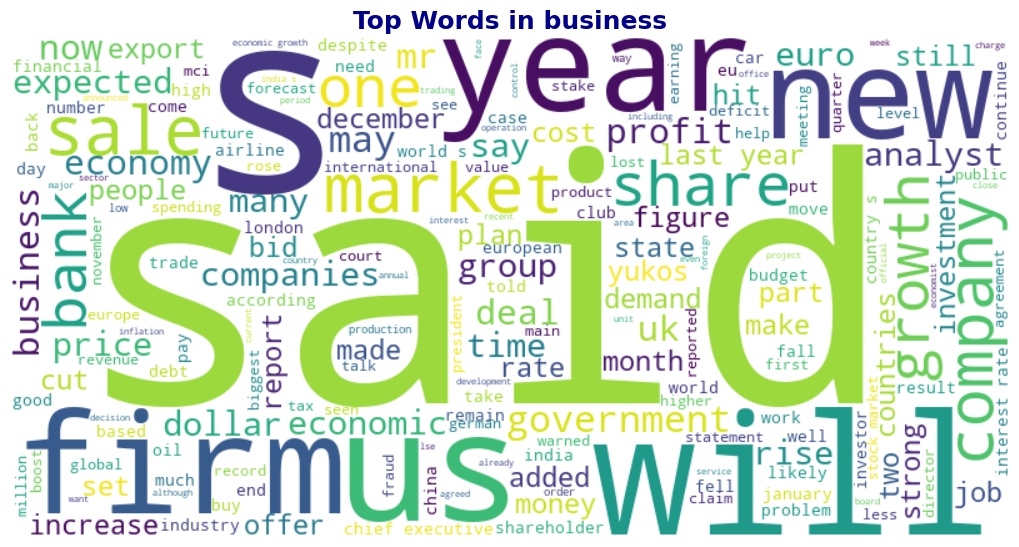

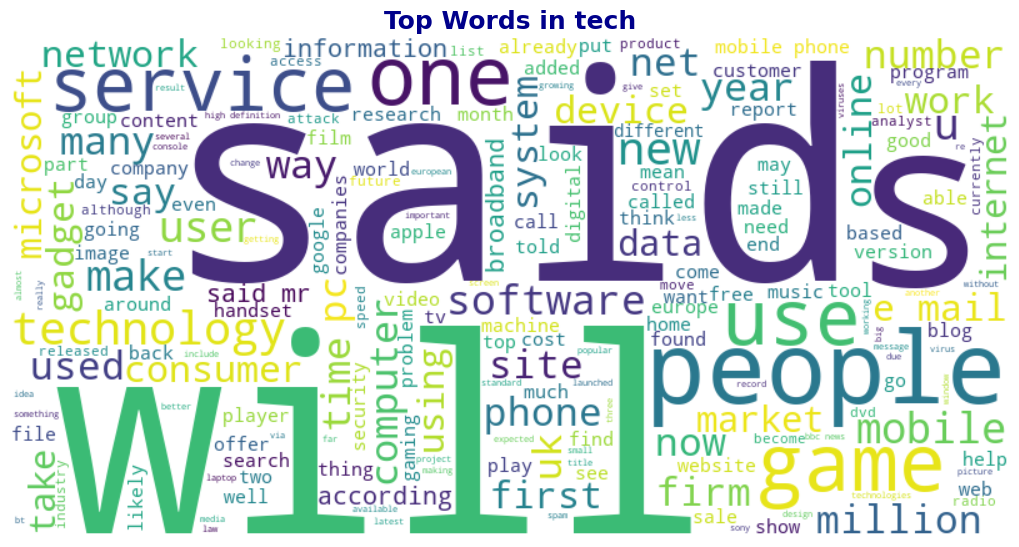

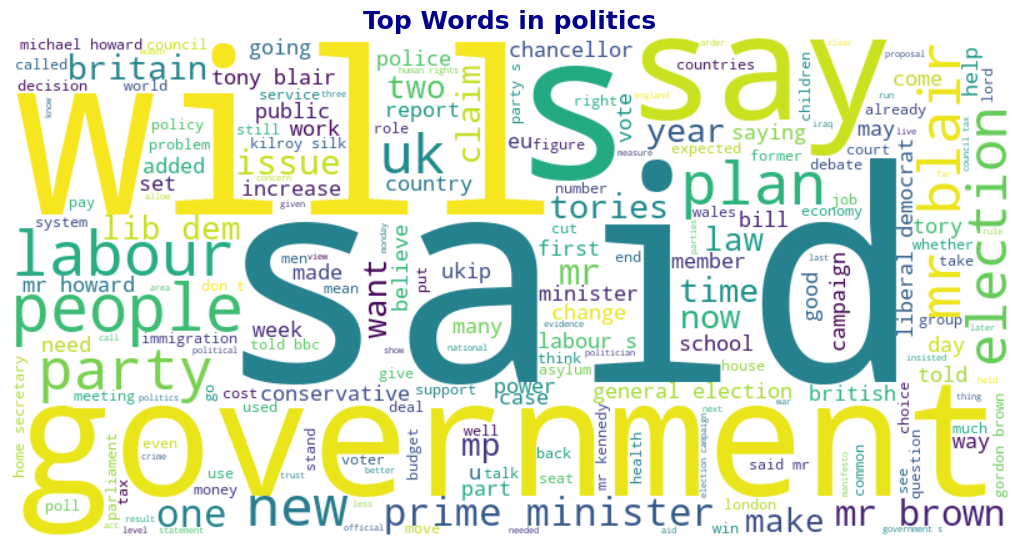

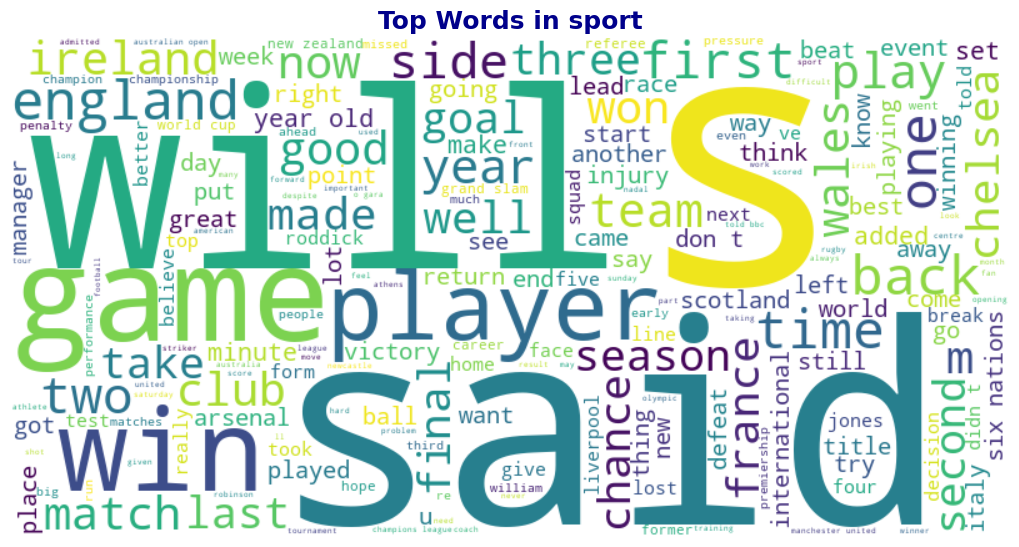

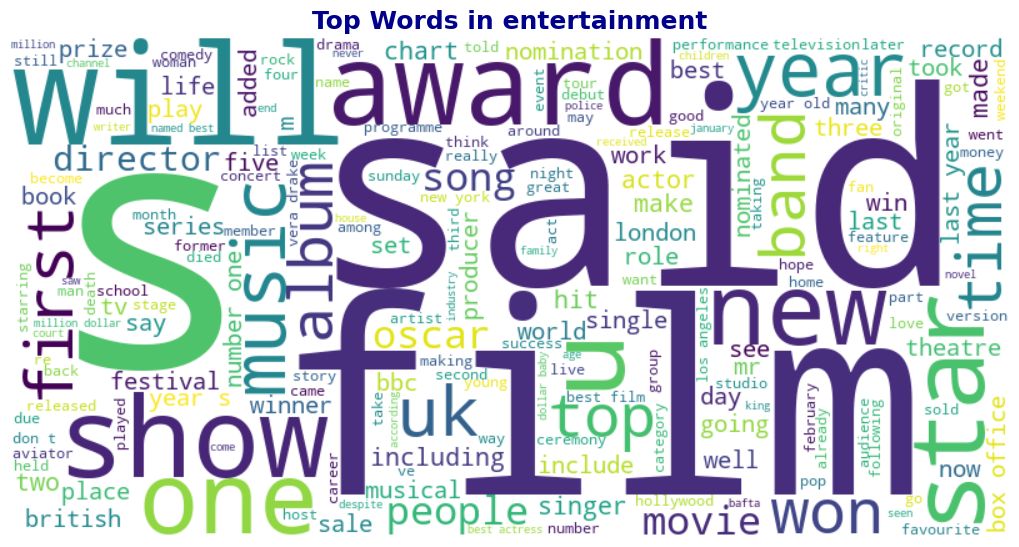

In [13]:
# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18, fontweight='bold', color='darkblue')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# Generate word clouds for each category
categories = bbc_df['Category'].unique()
for category in categories:
    text = ' '.join(bbc_df[bbc_df['Category'] == category]['Text'])
    generate_wordcloud(text, f'Top Words in {category}')

# Data Preprocessing

In [14]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

* Lower Casing & Punctuation

In [15]:
def normalize_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation using regex
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    return text

# Apply the normalization function to the Text column
bbc_df['Text'] = bbc_df['Text'].apply(normalize_text)

* Tokenization & Stopwords Removal 

In [16]:
# Function to remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Function to tokenize text
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

* Stemming & Lemmatization

In [17]:
# Function to apply stemming
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

# Function to apply lemmatization
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [18]:
# Preprocess the 'Text' column
bbc_df['Text'] = bbc_df['Text'].apply(normalize_text)
bbc_df['Text'] = bbc_df['Text'].apply(tokenize_text)
bbc_df['Text'] = bbc_df['Text'].apply(remove_stopwords)
bbc_df['Text'] = bbc_df['Text'].apply(stem_tokens)
bbc_df['Text'] = bbc_df['Text'].apply(lemmatize_tokens)

In [19]:
bbc_df['Text'] = bbc_df['Text'].apply(lambda tokens: ' '.join(tokens))

# Feature Extraction

In [20]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(bbc_df['Text'])
y = bbc_df['Category']

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("Training set shape (X_train):", X_train.shape)
print("Testing set shape (X_test):", X_test.shape)
print("Training set shape (y_train):", y_train.shape)
print("Testing set shape (y_test):", y_test.shape)

Training set shape (X_train): (1192, 535147)
Testing set shape (X_test): (298, 535147)
Training set shape (y_train): (1192,)
Testing set shape (y_test): (298,)


In [22]:
# List of classifiers to evaluate
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

In [23]:
# Initialize lists to store results
classifier_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
confusion_matrices = []

# Evaluate each classifier
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predict the labels for the testing set
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Append results to lists
    classifier_names.append(name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=y.unique())
    confusion_matrices.append(conf_matrix)
    
    # Print classification report
    print(f'{name} Classification Report:')
    print(classification_report(y_test, y_pred, target_names=y.unique()))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

     business       0.95      0.99      0.97        75
         tech       0.94      0.98      0.96        46
     politics       0.96      0.93      0.95        56
        sport       0.95      1.00      0.98        63
entertainment       1.00      0.90      0.95        58

     accuracy                           0.96       298
    macro avg       0.96      0.96      0.96       298
 weighted avg       0.96      0.96      0.96       298

Naive Bayes Classification Report:
               precision    recall  f1-score   support

     business       0.99      0.97      0.98        75
         tech       1.00      0.96      0.98        46
     politics       0.95      0.98      0.96        56
        sport       1.00      1.00      1.00        63
entertainment       0.97      0.98      0.97        58

     accuracy                           0.98       298
    macro avg       0.98      0.98   

In [24]:
# Convert metrics to DataFrame
metrics_df = pd.DataFrame({
    'Classifier': classifier_names,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

In [25]:
import contextlib
import warnings

@contextlib.contextmanager
def suppress_warnings():
    """
    Context manager to temporarily suppress all warnings.
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yield

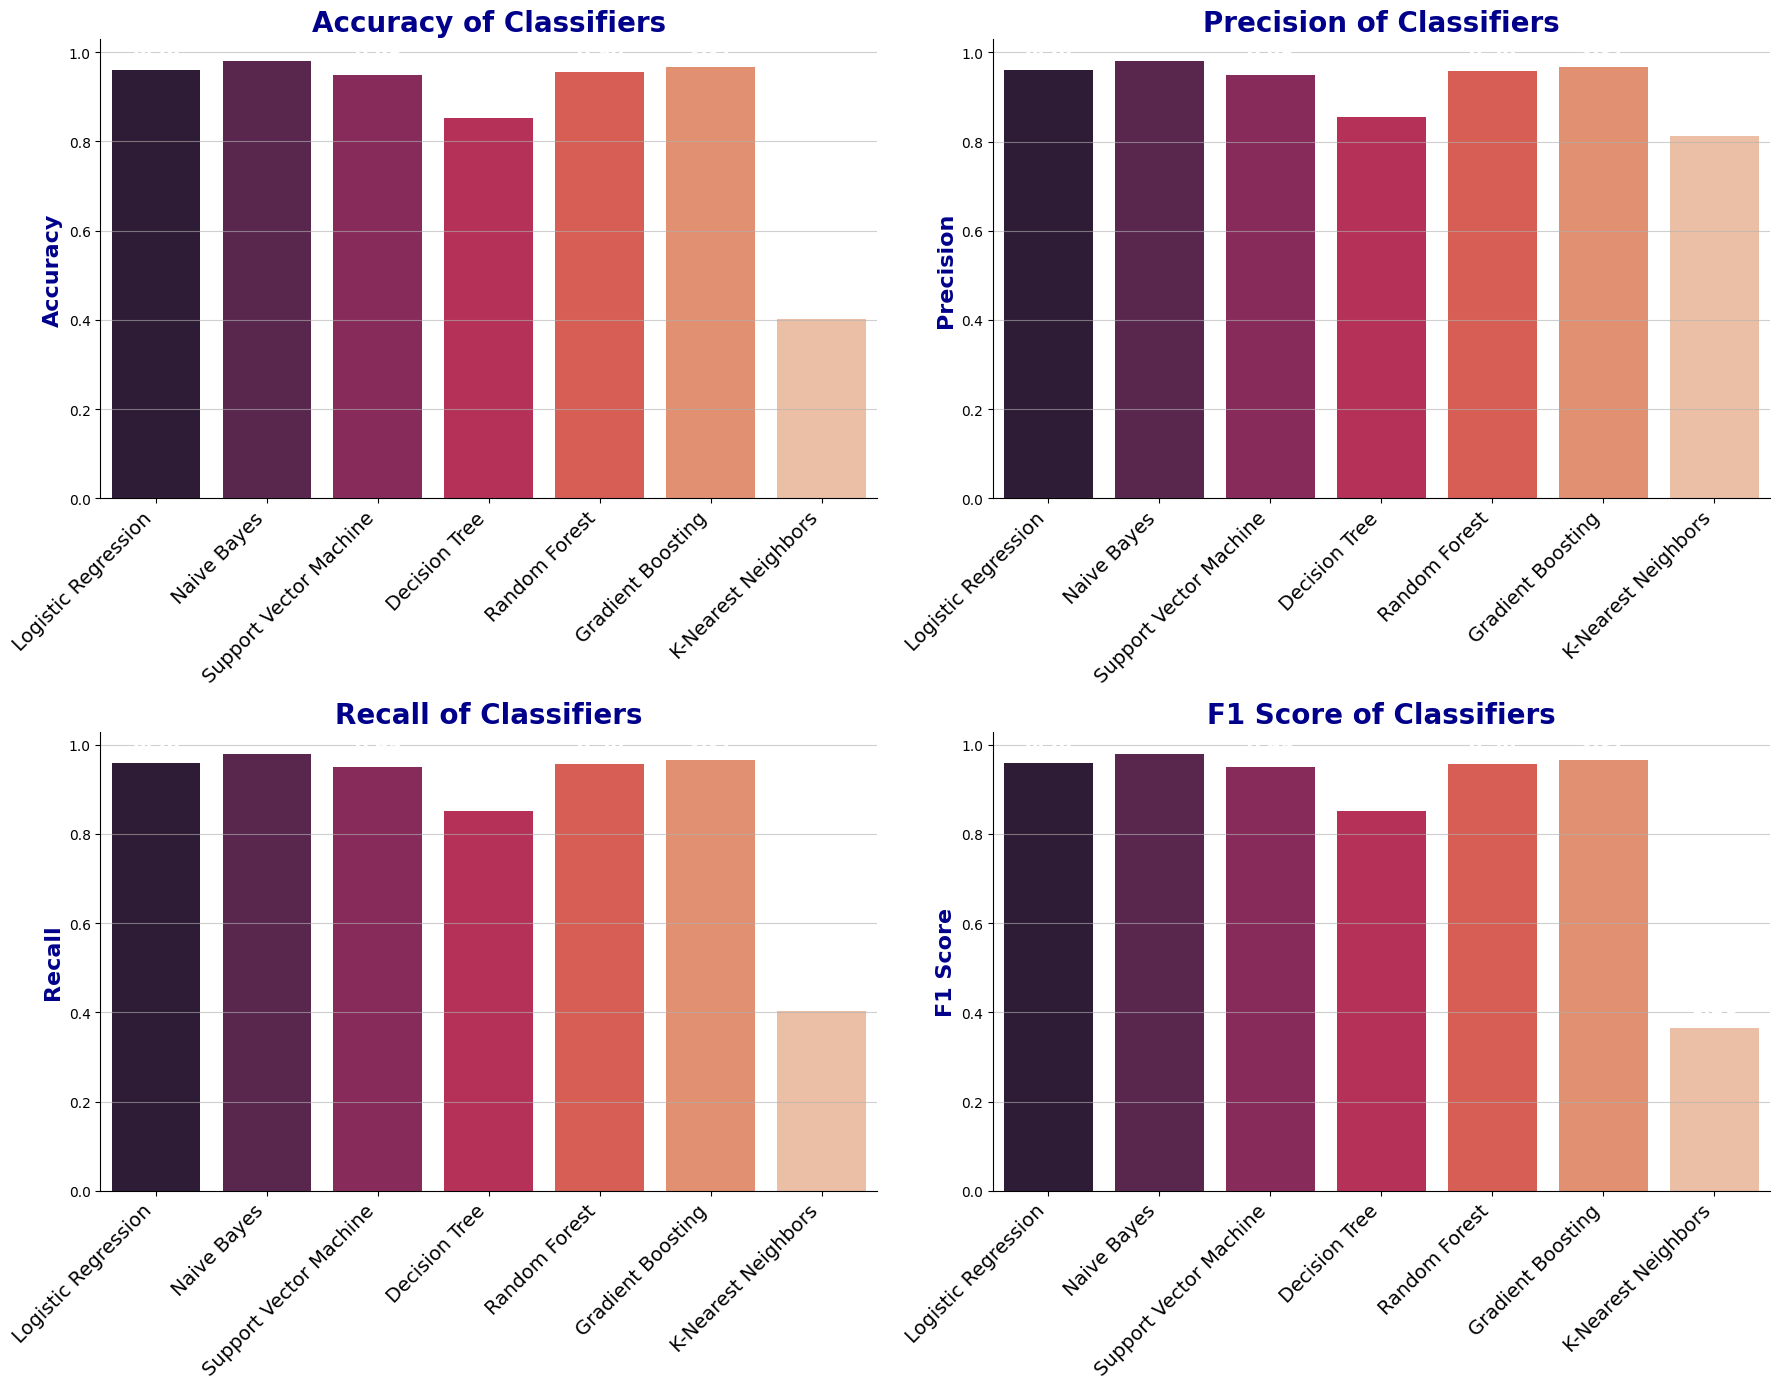

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

def add_annotations(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    xytext=(0, 8), 
                    textcoords='offset points',
                    fontsize=14, fontweight='bold', color='white')

def style_subplot(ax, title, ylabel):
    ax.set_title(title, fontsize=20, fontweight='bold', color='darkblue')
    ax.set_xlabel('')
    ax.set_ylabel(ylabel, fontsize=16, fontweight='bold', color='darkblue')
    ax.set_xticks(range(len(metrics_df['Classifier'])))
    ax.set_xticklabels(metrics_df['Classifier'], rotation=45, ha='right', fontsize=14, color='black')
    ax.grid(axis='y', linestyle='-', linewidth=0.8, alpha=0.6)  # Add grid lines with different style
    ax.spines['top'].set_visible(False)  
    ax.spines['right'].set_visible(False) 

palette = sns.color_palette('rocket', n_colors=len(metrics_df['Classifier']))

# Use the context manager to suppress warnings
with suppress_warnings():
    sns.barplot(x='Classifier', y='Accuracy', data=metrics_df, ax=axes[0, 0], palette=palette)
    style_subplot(axes[0, 0], 'Accuracy of Classifiers', 'Accuracy')
    add_annotations(axes[0, 0])

    sns.barplot(x='Classifier', y='Precision', data=metrics_df, ax=axes[0, 1], palette=palette)
    style_subplot(axes[0, 1], 'Precision of Classifiers', 'Precision')
    add_annotations(axes[0, 1])

    sns.barplot(x='Classifier', y='Recall', data=metrics_df, ax=axes[1, 0], palette=palette)
    style_subplot(axes[1, 0], 'Recall of Classifiers', 'Recall')
    add_annotations(axes[1, 0])

    sns.barplot(x='Classifier', y='F1 Score', data=metrics_df, ax=axes[1, 1], palette=palette)
    style_subplot(axes[1, 1], 'F1 Score of Classifiers', 'F1 Score')
    add_annotations(axes[1, 1])

plt.tight_layout()
plt.show()

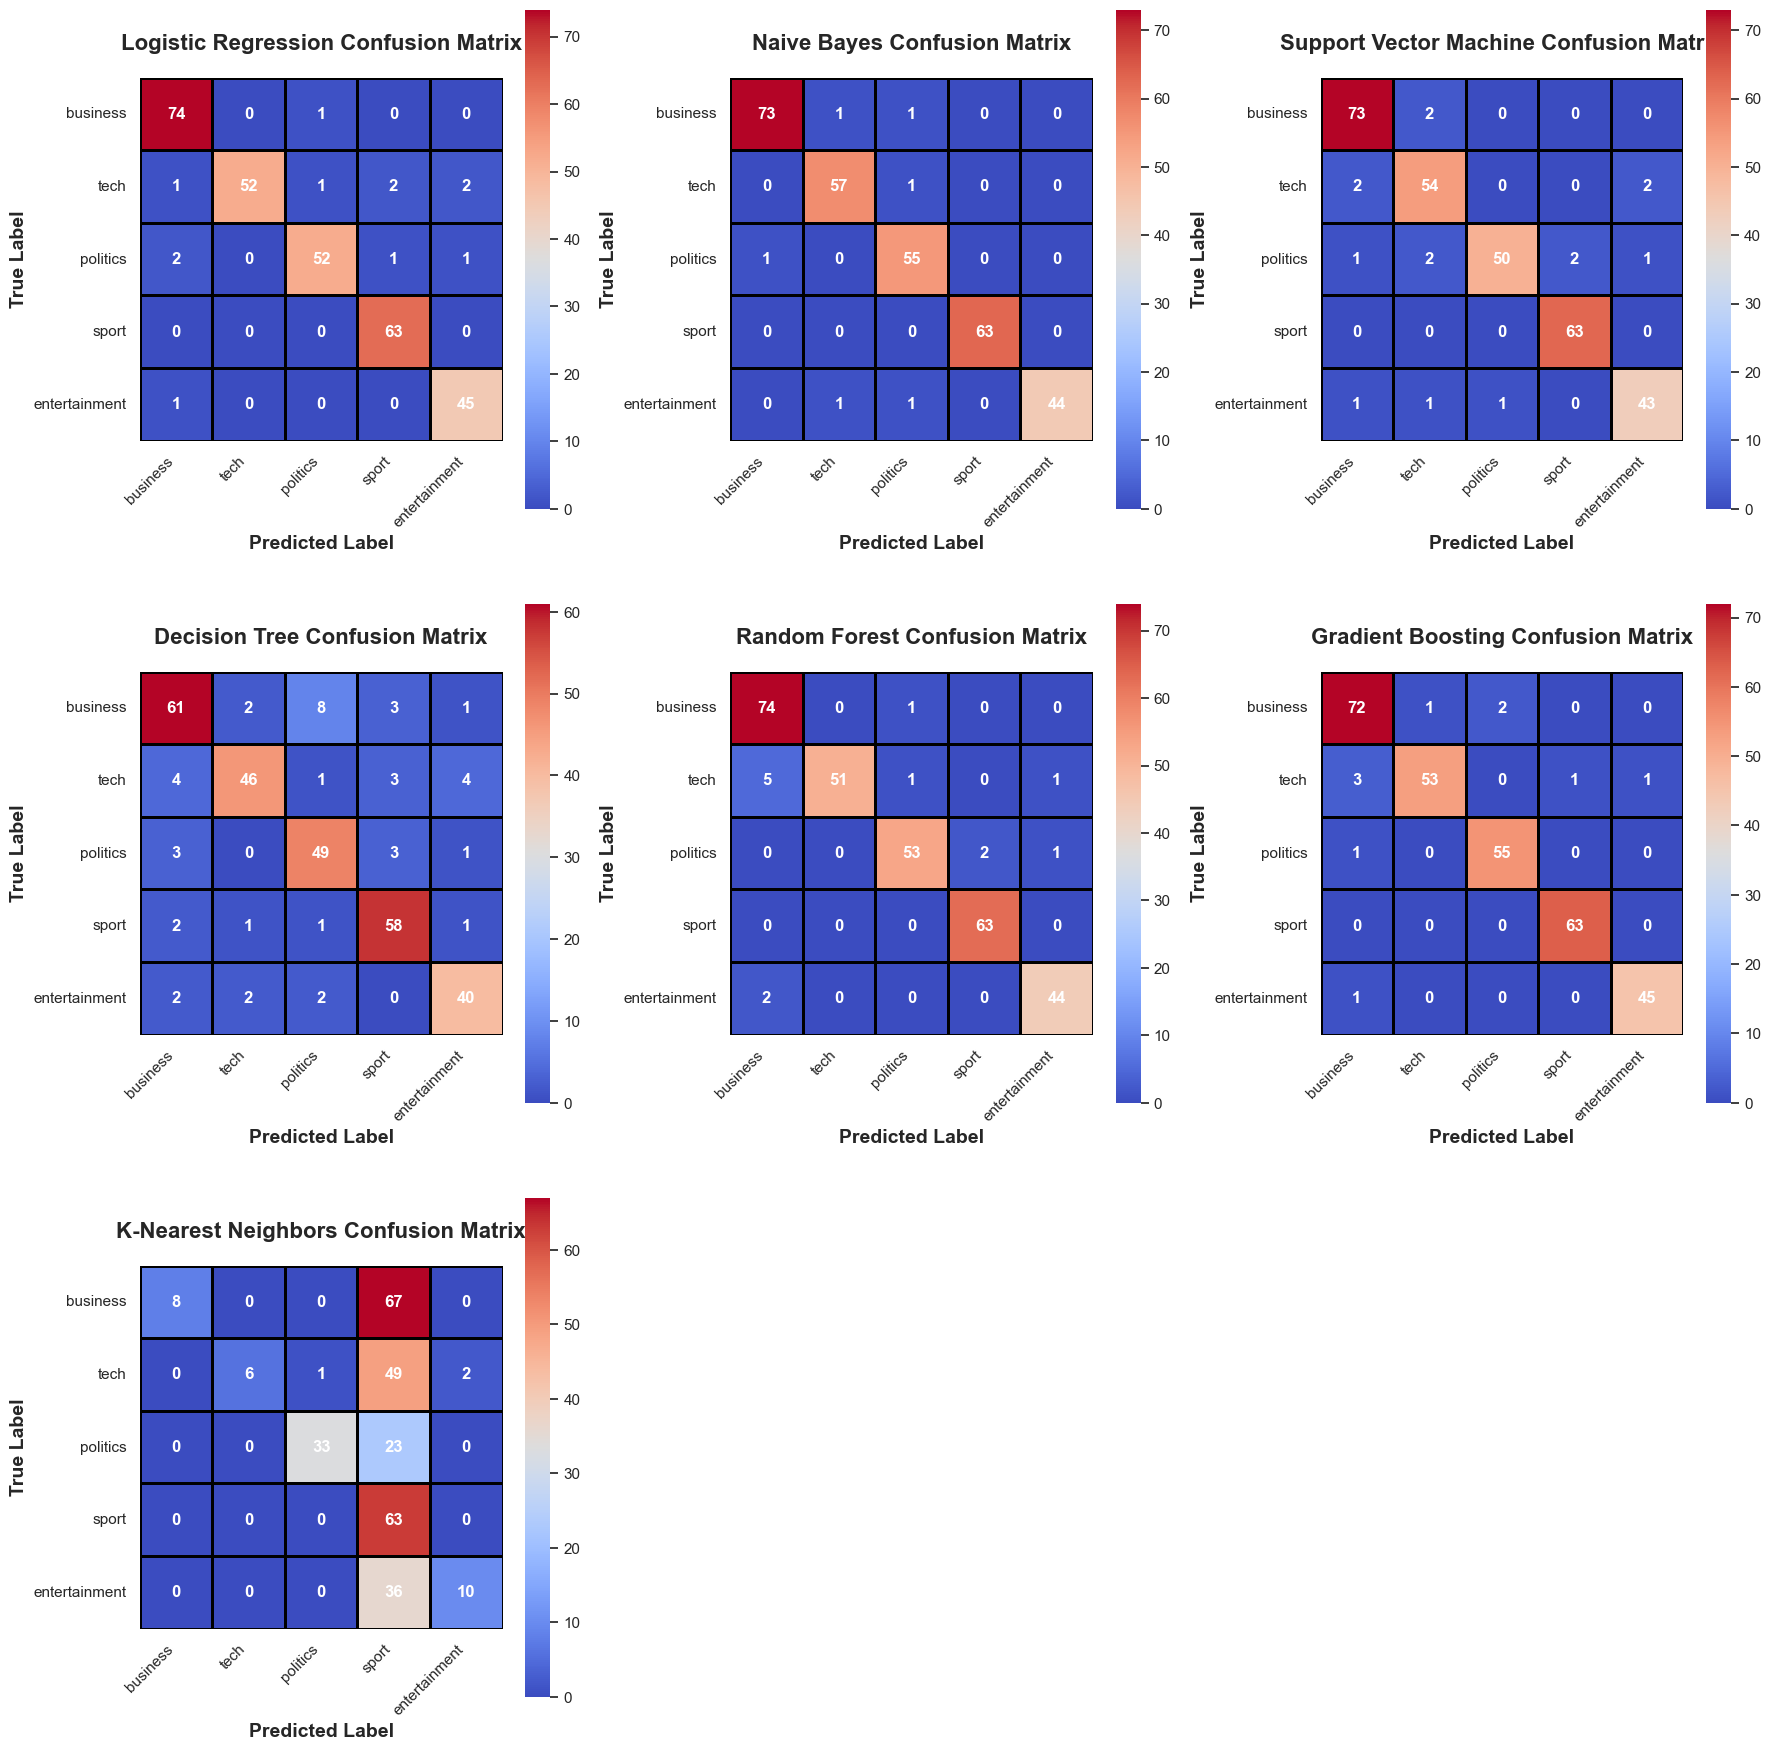

In [27]:
# Apply Seaborn style
sns.set(style='darkgrid', palette='muted')

# Create a figure with a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))
axes = axes.flatten()

# Define a function for adding annotations
def annotate_heatmap(ax, data):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j + 0.5, i + 0.5, f'{data[i, j]:d}',
                    ha='center', va='center', color='white', fontsize=12, fontweight='bold')

# Plot each confusion matrix
for i, (name, conf_matrix) in enumerate(zip(classifier_names, confusion_matrices)):
    sns.heatmap(conf_matrix, annot=False, cmap='coolwarm', ax=axes[i], 
                xticklabels=y.unique(), yticklabels=y.unique(),
                cbar=True, square=True, linewidths=1, linecolor='black', 
                vmin=0, vmax=conf_matrix.max())
    annotate_heatmap(axes[i], conf_matrix)
    axes[i].set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('True Label', fontsize=14, fontweight='bold')
    axes[i].set_title(f'{name} Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)

# Hide any unused subplots
for j in range(len(classifier_names), len(axes)):
    fig.delaxes(axes[j])

# Improve layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
import plotly.graph_objects as go

# DataFrame
data = {
    'Classifier': metrics_df['Classifier'],
    'Accuracy': metrics_df['Accuracy'].round(2),
    'Precision': metrics_df['Precision'].round(2),
    'Recall': metrics_df['Recall'].round(2),
    'F1 Score': metrics_df['F1 Score'].round(2)
}
table_df = pd.DataFrame(data)

# Create the table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(table_df.columns),
        fill_color='royalblue',
        align='center',
        font=dict(size=16, color='white')
    ),
    cells=dict(
        values=[table_df[col] for col in table_df.columns],
        fill_color=[
            ['#f9f9f9', '#f0f0f0'] * (len(table_df) // 2 + 1),
            ['#f0f0f0', '#f9f9f9'] * (len(table_df) // 2 + 1)
        ],
        align='center',
        font=dict(size=14, color='black')
    )
)])

# Update layout
fig.update_layout(
    title_text='Metrics Table',
    title_x=0.5,
    title_font=dict(size=24, family='Verdana'),
    height=400,
    margin=dict(l=20, r=20, b=20, t=60)
)
# Show the table
fig.show()

### Results Summary Analysis

#### 1: Naive Bayes:

* Best Performance: This model has the highest accuracy (0.980), precision (0.980), recall (0.980), and F1 score (0.980).
* Recommendation: Given its superior performance, Naive Bayes is highly recommended for this classification task.

#### 2: Gradient Boosting:

* Second Best: It achieves the second-highest accuracy (0.966), precision (0.967), recall (0.966), and F1 score (0.966).
* Recommendation: Gradient Boosting is a robust alternative, especially if you seek a model that balances performance and interpretability.

#### 3: Logistic Regression:

* Consistently Good: With an accuracy of 0.960 and similarly high precision, recall, and F1 scores, this model performs reliably well.
* Recommendation: Logistic Regression is a good option due to its simplicity and interpretability.

#### 4: Random Forest:

* Strong Performance: Accuracy of 0.953, with slightly higher precision (0.956).
* Recommendation: Random Forest is recommended for its good balance of accuracy and robustness against overfitting.

#### 5: SVM:

* Solid Performance: Accuracy of 0.950, with comparable precision, recall, and F1 scores.
* Recommendation: SVM is a reliable choice, particularly effective for binary or linearly separable data.

#### 6: Decision Tree:

* Moderate Performance: Accuracy of 0.859, precision of 0.861.
* Recommendation: Decision Tree can be useful for interpretability and simple decision rules but is outperformed by ensemble methods.

#### 7: K-Nearest Neighbors:

* Lowest Performance: Accuracy of 0.403, despite high precision (0.813) due to poor recall (0.403) and F1 score (0.365).
* Recommendation: KNN is not recommended for this dataset due to its significantly lower overall performance.